In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from models import CNN1DText
#import json
import random
import os
from data_process import EmbeddingManager


#import os

from evaluation_tool import EvaluationManager

print("creating model")
used_embedding = 'sgns.zhihu.word'
embedding_dir = 'embedding_tensor'
load_cache_model = "model_cache/model"

embedding_manager = EmbeddingManager(used_embedding, embedding_dir)


creating model


In [2]:
# prepare data
print("loading data")
feature_list, target_list = embedding_manager.load_data('traning_data.json')
feature_list_test, target_list_test = embedding_manager.load_data('testing_data.json')


loading data
size 6280 -> 6143
size 320 -> 306


In [9]:
class CNN1DTextMean(CNN1DText):
    def forward(self, x):
        # add and remove the extra N=1 dummy dimention to leverage other procedure which can only handle such form, 
        # such as those traning algorithm.
        # (1, L)
        x = self.batch_forward(torch.squeeze(x,0))
        return torch.unsqueeze(torch.mean(x,0),0) #(1, class_num)
    
class CNN1DTextMax(CNN1DText):
    def forward(self, x):
        # add and remove the extra N=1 dummy dimention to leverage other procedure which can only handle such form, 
        # such as those traning algorithm.
        # (1, L)
        x = self.batch_forward(torch.squeeze(x,0))
        return torch.unsqueeze(torch.max(x,0)[0],0) #(1, class_num)


In [4]:
model = CNN1DTextMean(embed_num = 259922, embed_dim = 300, class_num = 2, kernel_num = 100, kernel_sizes = (3,4,5),
                dropout = 0.5)

embedding_obj = torch.load(os.path.join(embedding_dir, used_embedding))
model.use_pretrained_embedding(embedding_obj['tensor'], non_trainable = True)


In [5]:
cuda = True
if cuda:

    feature_list = [feature.cuda() for feature in feature_list]
    target_list = [target.cuda() for target in target_list]
    feature_list_test = [feature.cuda() for feature in feature_list_test]
    target_list_test = [target.cuda() for target in target_list_test]

    model.cuda()


In [12]:
# training
lr = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
len_data = len(feature_list)
n_iter = 20000

print("start training")
# optimizer = torch.optim.SGD(model.parameters(), lr=0.0001)
loss_cache = []
for i in range(n_iter):
    idx = random.randint(0,len_data-1)
    feature, target = feature_list[idx], target_list[idx]
    
    optimizer.zero_grad()
    out = model(feature) # before softmax(log_softmax)
    loss = F.cross_entropy(out, target, size_average=False)
    loss_cache.append(loss.item())
    loss.backward()
    optimizer.step()
    
    if len(loss_cache) == 1000:
        loss_est = sum(loss_cache)/len(loss_cache)
        loss_cache = []
        print(f'loss: {loss_est} {i}/{n_iter}')


start training


D:\anaconda\lib\site-packages\torch\nn\functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


loss: 0.5327366980910301 999/20000
loss: 0.5193258919715882 1999/20000
loss: 0.5376055925488472 2999/20000
loss: 0.5195887275636196 3999/20000
loss: 0.4955071797668934 4999/20000
loss: 0.5216926597058773 5999/20000
loss: 0.5490505165755749 6999/20000
loss: 0.4940955646634102 7999/20000
loss: 0.5034801624715328 8999/20000
loss: 0.49654267650842665 9999/20000
loss: 0.544945903301239 10999/20000
loss: 0.5260658439695836 11999/20000
loss: 0.4914745786339045 12999/20000
loss: 0.5480733099281788 13999/20000
loss: 0.49690695510804656 14999/20000
loss: 0.5236796655058861 15999/20000
loss: 0.5289269909858704 16999/20000
loss: 0.5243995447456836 17999/20000
loss: 0.5015852240920067 18999/20000
loss: 0.49334284277260304 19999/20000


In [13]:


import datetime
timestamp = str(datetime.datetime.now()).replace(':','-')
cache_path = "model_cache/model"+timestamp
torch.save(model.state_dict(), cache_path)


print(f'save cache model {cache_path}')

    


save cache model model_cache/model2018-11-16 11-59-39.711925
train acc 0.7841445547777959
tensor([[4762,   39],
        [1287,   55]])
test acc 0.7843137254901961
tensor([[239,   3],
        [ 63,   1]])


In [ ]:
model.train(False)

evaluation_manager = EvaluationManager(model, embedding_manager, cuda = cuda)
get_acc = evaluation_manager.get_acc
confuse_matrix = evaluation_manager.confuse_matrix
analysis_doc = evaluation_manager.analysis_doc


print(f'train acc {get_acc(feature_list, target_list)}') # 0.94
print(confuse_matrix(feature_list, target_list))

print(f'test acc {get_acc(feature_list_test, target_list_test)}') #
print(confuse_matrix(feature_list_test, target_list_test))


In [14]:


good_list = analysis_doc('extracted_text/AI报告_杨帆_117106010714.docx.txt')



Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\YIYUEZ~1\AppData\Local\Temp\jieba.cache
Loading model cost 1.082 seconds.
Prefix dict has been built succesfully.


none count: 174 / 11644
none count: 175 / 7350


<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

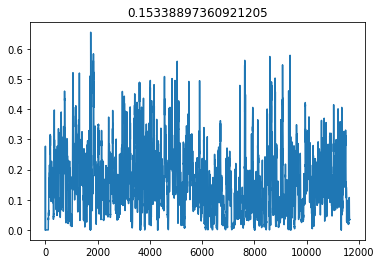

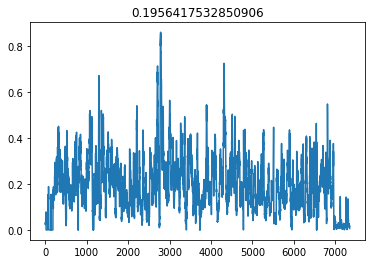

In [15]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

plt.plot(good_list)
plt.title(np.mean(good_list))
plt.show()
plt.plot(bad_list)
plt.title(np.mean(bad_list))
plt.show(np.mean(bad_list))

In [17]:
F.max_pool1d(torch.randn(1,100,10),20)

RuntimeError: Given input size: (100x1x10). Calculated output size: (100x1x0). Output size is too small at c:\programdata\miniconda3\conda-bld\pytorch_1533090623466\work\aten\src\thnn\generic/SpatialDilatedMaxPooling.c:67

In [16]:
F.max_pool1d?

In [20]:
torch.randn(2,2).squeeze(1)

tensor([[-0.6660,  0.0220],
        [-0.2273,  0.1507]])

In [21]:
nn.Conv1d?

In [22]:
F.max_pool1d?

In [27]:
F.max_pool1d(torch.randn(1,100,30),25,stride=1).shape

torch.Size([1, 100, 6])

In [4]:
import models

In [13]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
model = models.CNNV2(embed_num = 259922, embed_dim = 300, class_num = 2, kernel_num = 100, kernel_sizes = (3,4,5),
                dropout = 0.5)

embedding_obj = torch.load(os.path.join(embedding_dir, used_embedding))
model.use_pretrained_embedding(embedding_obj['tensor'], non_trainable = True)


In [15]:
cuda = True
if cuda:

    feature_list = [feature.cuda() for feature in feature_list]
    target_list = [target.cuda() for target in target_list]
    feature_list_test = [feature.cuda() for feature in feature_list_test]
    target_list_test = [target.cuda() for target in target_list_test]

    model.cuda()


In [16]:
# training
lr = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
len_data = len(feature_list)
n_iter = 20000

print("start training")
# optimizer = torch.optim.SGD(model.parameters(), lr=0.0001)
loss_cache = []
for i in range(n_iter):
    idx = random.randint(0,len_data-1)
    feature, target = feature_list[idx], target_list[idx]
    
    optimizer.zero_grad()
    out = model(feature) # before softmax(log_softmax)
    out = out.squeeze(2)
    loss = F.cross_entropy(out, target, size_average=False)
    loss_cache.append(loss.item())
    loss.backward()
    optimizer.step()
    
    if len(loss_cache) == 1000:
        loss_est = sum(loss_cache)/len(loss_cache)
        loss_cache = []
        print(f'loss: {loss_est} {i}/{n_iter}')


start training


D:\anaconda\lib\site-packages\torch\nn\functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


loss: 0.5838185234367848 999/20000
loss: 0.5266957989633083 1999/20000
loss: 0.5040717175602913 2999/20000
loss: 0.5538142917901278 3999/20000
loss: 0.503610973417759 4999/20000
loss: 0.5076092751920224 5999/20000
loss: 0.4736355343610048 6999/20000
loss: 0.47645870453119277 7999/20000
loss: 0.4486696624606848 8999/20000
loss: 0.4469425745159388 9999/20000
loss: 0.45487523020803927 10999/20000
loss: 0.4649599179923534 11999/20000
loss: 0.48070262160897254 12999/20000
loss: 0.4216219006627798 13999/20000
loss: 0.41406380134820936 14999/20000
loss: 0.44795721797645094 15999/20000
loss: 0.3917401671260595 16999/20000
loss: 0.3780293843597174 17999/20000
loss: 0.40065599703788757 18999/20000
loss: 0.35069197297096255 19999/20000


In [17]:
model.train(False)

evaluation_manager = EvaluationManager(model, embedding_manager, cuda = cuda)
get_acc = evaluation_manager.get_acc
confuse_matrix = evaluation_manager.confuse_matrix
analysis_doc = evaluation_manager.analysis_doc


print(f'train acc {get_acc(feature_list, target_list)}') # 0.94
print(confuse_matrix(feature_list, target_list))

print(f'test acc {get_acc(feature_list_test, target_list_test)}') #
print(confuse_matrix(feature_list_test, target_list_test))


train acc 0.882305062672961
tensor([[4701,  100],
        [ 623,  719]])
test acc 0.738562091503268
tensor([[222,  20],
        [ 60,   4]])


In [18]:
# training
model.train(True)

lr = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
len_data = len(feature_list)
n_iter = 20000

print("start training")
# optimizer = torch.optim.SGD(model.parameters(), lr=0.0001)
loss_cache = []
for i in range(n_iter):
    idx = random.randint(0,len_data-1)
    feature, target = feature_list[idx], target_list[idx]
    
    optimizer.zero_grad()
    out = model(feature) # before softmax(log_softmax)
    out = out.squeeze(2)
    loss = F.cross_entropy(out, target, size_average=False)
    loss_cache.append(loss.item())
    loss.backward()
    optimizer.step()
    
    if len(loss_cache) == 1000:
        loss_est = sum(loss_cache)/len(loss_cache)
        loss_cache = []
        print(f'loss: {loss_est} {i}/{n_iter}')


start training


D:\anaconda\lib\site-packages\torch\nn\functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


loss: 0.3781767908930779 999/20000
loss: 0.36824610278010367 1999/20000
loss: 0.4019898724406958 2999/20000
loss: 0.34581310181319713 3999/20000
loss: 0.3762867725491524 4999/20000
loss: 0.34769866631925106 5999/20000
loss: 0.3782634024322033 6999/20000
loss: 0.34607590824365614 7999/20000
loss: 0.31943156880140305 8999/20000
loss: 0.3329312991350889 9999/20000
loss: 0.31461223413050177 10999/20000
loss: 0.31078818839788436 11999/20000
loss: 0.3091557001173496 12999/20000
loss: 0.28777206191420557 13999/20000
loss: 0.2698608704507351 14999/20000
loss: 0.2911558743864298 15999/20000
loss: 0.2702375695407391 16999/20000
loss: 0.2667164943665266 17999/20000
loss: 0.273317386329174 18999/20000
loss: 0.2600772050768137 19999/20000


In [19]:
model.train(False)

print(f'train acc {get_acc(feature_list, target_list)}') # 0.94
print(confuse_matrix(feature_list, target_list))

print(f'test acc {get_acc(feature_list_test, target_list_test)}') #
print(confuse_matrix(feature_list_test, target_list_test))


train acc 0.9399316294969885
tensor([[4718,   83],
        [ 286, 1056]])
test acc 0.7679738562091504
tensor([[221,  21],
        [ 50,  14]])


In [20]:
# training
model.train(True)

lr = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
len_data = len(feature_list)
n_iter = 20000

print("start training")
# optimizer = torch.optim.SGD(model.parameters(), lr=0.0001)
loss_cache = []
for i in range(n_iter):
    idx = random.randint(0,len_data-1)
    feature, target = feature_list[idx], target_list[idx]
    
    optimizer.zero_grad()
    out = model(feature) # before softmax(log_softmax)
    out = out.squeeze(2)
    loss = F.cross_entropy(out, target, size_average=False)
    loss_cache.append(loss.item())
    loss.backward()
    optimizer.step()
    
    if len(loss_cache) == 1000:
        loss_est = sum(loss_cache)/len(loss_cache)
        loss_cache = []
        print(f'loss: {loss_est} {i}/{n_iter}')


start training


D:\anaconda\lib\site-packages\torch\nn\functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


loss: 0.25461153174936774 999/20000
loss: 0.2528211486637592 1999/20000
loss: 0.2713071506023407 2999/20000
loss: 0.24191658201813698 3999/20000
loss: 0.2373641375005245 4999/20000
loss: 0.26614417853206396 5999/20000
loss: 0.2816039807796478 6999/20000
loss: 0.22892168626189233 7999/20000
loss: 0.24535555031895637 8999/20000
loss: 0.20499914598464966 9999/20000
loss: 0.22348758828639984 10999/20000
loss: 0.20109221175312997 11999/20000
loss: 0.22236038109660147 12999/20000
loss: 0.24119005981087685 13999/20000
loss: 0.23263146221637726 14999/20000
loss: 0.18983656638860702 15999/20000
loss: 0.1937137579023838 16999/20000
loss: 0.23495113775134085 17999/20000
loss: 0.21286076253652572 18999/20000
loss: 0.20438476675748826 19999/20000


In [21]:
model.train(False)

print(f'train acc {get_acc(feature_list, target_list)}') # 0.94
print(confuse_matrix(feature_list, target_list))

print(f'test acc {get_acc(feature_list_test, target_list_test)}') #
print(confuse_matrix(feature_list_test, target_list_test))


train acc 0.9689076998209344
tensor([[4758,   43],
        [ 148, 1194]])
test acc 0.7712418300653595
tensor([[219,  23],
        [ 47,  17]])


In [22]:
# training
model.train(True)

lr = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
len_data = len(feature_list)
n_iter = 20000

print("start training")
# optimizer = torch.optim.SGD(model.parameters(), lr=0.0001)
loss_cache = []
for i in range(n_iter):
    idx = random.randint(0,len_data-1)
    feature, target = feature_list[idx], target_list[idx]
    
    optimizer.zero_grad()
    out = model(feature) # before softmax(log_softmax)
    out = out.squeeze(2)
    loss = F.cross_entropy(out, target, size_average=False)
    loss_cache.append(loss.item())
    loss.backward()
    optimizer.step()
    
    if len(loss_cache) == 1000:
        loss_est = sum(loss_cache)/len(loss_cache)
        loss_cache = []
        print(f'loss: {loss_est} {i}/{n_iter}')


start training


D:\anaconda\lib\site-packages\torch\nn\functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


loss: 0.21850189217925073 999/20000
loss: 0.1900887493491173 1999/20000
loss: 0.20779893946647643 2999/20000
loss: 0.2206921116411686 3999/20000
loss: 0.2312840704470873 4999/20000
loss: 0.2014151332527399 5999/20000
loss: 0.16978893426060676 6999/20000
loss: 0.21573469883203505 7999/20000
loss: 0.17374648222327232 8999/20000
loss: 0.2080708215981722 9999/20000
loss: 0.16797767423093318 10999/20000
loss: 0.2030388533771038 11999/20000
loss: 0.16831581154465675 12999/20000
loss: 0.16543469542264938 13999/20000
loss: 0.15847708758711815 14999/20000
loss: 0.20450837597250937 15999/20000
loss: 0.20449055092036725 16999/20000
loss: 0.18024474328756332 17999/20000
loss: 0.13902878253161907 18999/20000
loss: 0.15294541066884995 19999/20000


In [23]:
model.train(False)

print(f'train acc {get_acc(feature_list, target_list)}') # 0.94
print(confuse_matrix(feature_list, target_list))

print(f'test acc {get_acc(feature_list_test, target_list_test)}') #
print(confuse_matrix(feature_list_test, target_list_test))


train acc 0.9734657333550383
tensor([[4779,   22],
        [ 141, 1201]])
test acc 0.8137254901960784
tensor([[231,  11],
        [ 46,  18]])


In [24]:
cache_path = "model_cache/model_CNNV2_201811161333"
torch.save(model.state_dict(), cache_path)
print(f'save cache model {cache_path}')


save cache model model_cache/model_CNNV2_201811161333
